In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import shutil
import os
from tqdm import tqdm

In [2]:
# create dataset
def word_2_onehot(word: str):
    assert len(word) == 5, (word, len(word))
    # print(word, len(word))
    sample = torch.zeros((26*len(word), ))
    for i in range(len(word)):
        sample[ 26*i + ord(word[i])-97] = 1   
    return sample

class WordDataset(Dataset):
    def __init__(self):
        data = pd.read_excel('../datafeatures_all.xlsx')
        data = data.to_numpy()
        self.data = data[:, 14:].astype(np.float64)
        self.words = data[:, 2]
        n = len(self.data)
        ## data processing ##
        # last 7 column normalization
        self.data[:, -7: ] = (self.data[:, -7: ] - self.data[:, -7: ].mean(axis=0)) / \
            self.data[:, -7: ].std(axis=0)

        self.targets = torch.FloatTensor(data[:, 5:12].astype(np.float64)/100)
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        ''' Return sample(R^130), target R^7 '''
        word = self.words[index]
        sample = self.data[index]
        target = self.targets[index]
        return word, torch.concat((word_2_onehot(word), sample)), target


In [3]:
dataset = WordDataset()

train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 16
train_loader = DataLoader(train_set, batch_size, True)
test_loader = DataLoader(test_set, 1, False)
print(dataset[10])

('shire', tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0

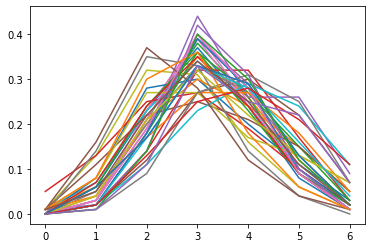

In [39]:
for _, _, x in test_loader:
    # plt.plot(np.arange(7), predicted[i].numpy().reshape(-1) )
    plt.plot(np.arange(7), x.numpy().reshape(-1) )

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(143, 64), nn.BatchNorm1d(64), nn.Dropout(0.5), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.Dropout(0.5), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(32, 7), nn.ReLU())
        self.softmax = nn.Softmax(1)
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return self.softmax(x)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MLP().to(device)
# criterion = nn.MSELoss()
criterion = nn.L1Loss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 500

tbar = tqdm(range(num_epochs))

best_so_far = float('inf')
best_epoch = -1

loss_weight = torch.FloatTensor([2, 1, 1, 1, 1, 1, 2])
def element_weighted_loss(y_hat, y):
    loss = criterion(y_hat, y)
    loss = loss * loss_weight
    # print(loss.shape)
    return torch.sum(loss.sum(axis=1) / loss_weight.sum())

model.train()
for e in tbar:
    batch_loss = []
    for _, sample, target in train_loader:
        sample, target = sample.to(device), target.to(device)
        # print(sample.shape)
        out = model(sample)
        # loss = criterion(out, target)
        loss = element_weighted_loss(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        batch_loss.append(loss.cpu().item())
    
    epoch_loss = sum(batch_loss)/len(batch_loss)
    tbar.set_postfix(loss=epoch_loss)

    if epoch_loss < best_so_far:
        best_so_far = epoch_loss
        best_epoch = e
        torch.save(model.state_dict(), 'best.pth')

    if e - best_epoch > 100:
        print('early stop!')
        break

torch.save(model.state_dict(), 'model.pth')
print(f'Finished with best loss: {best_so_far}')

100%|██████████| 500/500 [00:24<00:00, 20.68it/s, loss=0.301]

Finished with best loss: 0.2875138024489085


## evaluation

In [9]:
model.load_state_dict(torch.load('best.pth'))
model.eval()
total_loss = []
predicted = []
gt = []
words = []
criterion_eval = nn.L1Loss()
for word, sample, target in test_loader:
    sample, target = sample.to(device), target.to(device)
    # print(sample.shape)
    out = model(sample)
    loss = criterion_eval(out, target)  
    total_loss.append(loss.cpu().item())
    predicted.append(out.cpu().detach())
    gt.append(target.cpu().detach())
    words.append(word)

# print(total_loss)
print(np.array(total_loss).mean())

0.03663984859465725


## visualize the result on the test dataset

In [10]:
shutil.rmtree('./test/')
os.mkdir('./test')
for i in range(len(test_loader)):
    plt.plot(np.arange(7), predicted[i].numpy().reshape(-1), np.arange(7), gt[i].numpy().reshape(-1))
    plt.legend(['predicted', 'gt'])
    plt.savefig(f'test/{i}_`{words[i][0]}`.png')
    plt.close()

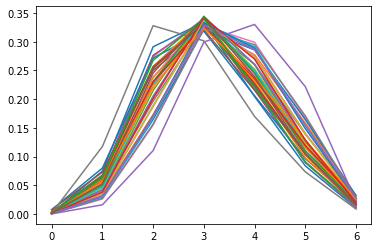

In [70]:
for i in range(len(predicted)):
    plt.plot(np.arange(7), predicted[i].numpy().reshape(-1) )
    # plt.plot(np.arange(7), gt[i].numpy().reshape(-1) )

## inference

In [9]:
test = word_2_onehot('eerie')
model(test.reshape(1, -1))

NameError: name 'word_2_onehot' is not defined